In [50]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

df_fixed=pd.read_csv('esios_data_full',index_col='Date',keep_date_col=True,parse_dates=True)
names=['Precio de Regulación Secundaria subir','Precio de Regulación Secundaria bajar','Precio mercado SPOT Diario','Demanda real']

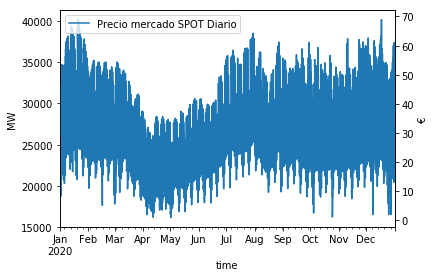

In [51]:
date1='2020-01-01'
date2='2020-12-31'

df_fixed=df_fixed[date1:date2]

fig, ax1 = plt.subplots()
df_fixed[names[3]].plot(ax=ax1)  # demand
ax1.set_xlabel('time')
ax1.set_ylabel('MW')

# secondary axis
ax2 = ax1.twinx()
df_fixed[names[2:3]].plot(ax=ax2)  # others
ax2.set_ylabel('€')

plt.show()

In [52]:
#Generate day/month/year variables

hours = df_fixed.index.hour
days = df_fixed.index.day
months = df_fixed.index.month
years = df_fixed.index.year

df_readed_1=pd.concat([df_fixed, pd.DataFrame(hours, index=df_fixed.index)], axis = 1)
df_readed_1=df_readed_1.rename(index=str, columns={'Date': 'Hora'})
df_readed_2=pd.get_dummies(df_readed_1,columns=['Hora'])
df_readed_2=pd.concat([df_readed_2, pd.DataFrame(hours, index=df_fixed.index)], axis = 1,names=['Hora'])
df_readed_2=df_readed_2.rename(index=str, columns={'Date': 'Hora'})

df_readed_2=pd.concat([df_readed_2, pd.DataFrame(days, index=df_fixed.index)], axis = 1,names=['Dia'])
df_readed_2=df_readed_2.rename(index=str, columns={'Date': 'Dia'})
df_readed_2=pd.get_dummies(df_readed_2,columns=['Dia'])
df_readed_2=pd.concat([df_readed_2, pd.DataFrame(days, index=df_fixed.index)], axis = 1,names=['Dia'])
df_readed_2=df_readed_2.rename(index=str, columns={'Date': 'Dia'})

df_readed_2=pd.concat([df_readed_2, pd.DataFrame(months, index=df_fixed.index)], axis = 1,names=['Mes'])
df_readed_2=df_readed_2.rename(index=str, columns={'Date': 'Mes'})
df_readed_2=pd.get_dummies(df_readed_2,columns=['Mes'])
df_readed_2=pd.concat([df_readed_2, pd.DataFrame(months, index=df_fixed.index)], axis = 1,names=['Mes'])
df_readed_2=df_readed_2.rename(index=str, columns={'Date': 'Mes'})

df_readed_2=pd.concat([df_readed_2, pd.DataFrame(years, index=df_fixed.index)], axis = 1,names=['Año'])
df_readed_2=df_readed_2.rename(index=str, columns={'Date': 'Año'})

df_readed_2=df_readed_2.set_index(['Año','Mes','Dia','Hora'],append=True)
df_readed_2.index.names=['Fecha','Año','Mes','Dia','Hora']

#Store dataset info 

max_spot=df_readed_2['Precio mercado SPOT Diario'].max()
min_spot=df_readed_2['Precio mercado SPOT Diario'].min()
max_demand=df_readed_2['Demanda real'].max()
min_demand=df_readed_2['Demanda real'].min()

#Generate demand and spot dataset

df_readed_3=pd.concat([df_readed_2['Precio mercado SPOT Diario'],df_readed_2['Demanda real']],axis=1)

df_spot=pd.DataFrame()
df_demand=pd.DataFrame()

#dfy generated and grouped by location
for i, dfnew in df_readed_3.groupby('Hora'):
    dfnew=dfnew.reset_index(level=['Fecha','Hora'], drop=True)
    f=int(i)
    a=str(f)
    df_model=pd.DataFrame()
    df_model['%a' % f]=dfnew['Precio mercado SPOT Diario']
    df_spot=pd.concat([df_spot,df_model], axis=1,join_axes=[df_model.index])
    df_model=pd.DataFrame()
    df_model['Demanda_%a' % f]=dfnew['Demanda real']
    df_demand=pd.concat([df_demand,df_model], axis=1,join_axes=[df_model.index])
df_demand=df_demand.reset_index(inplace=False)  
df_demand=pd.get_dummies(data=df_demand, columns=['Año', 'Mes','Dia'])

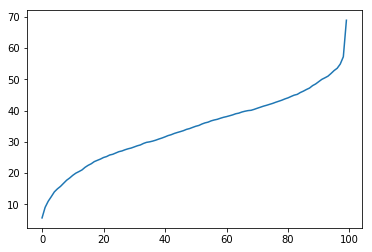

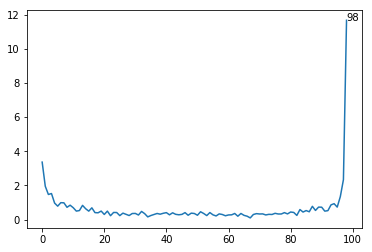

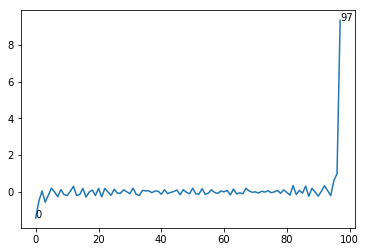

In [53]:
## exploratory analysis ##

temp_array=[()]

for quart_r in range(1,100+1):    
    temp_array=np.append(temp_array,np.percentile(df_readed_3['Precio mercado SPOT Diario'], quart_r))
    

plt.plot(temp_array)    
plt.show()

# distance between percentile values

dif_perct=[()]

for i in range(len(temp_array)-1):
    
    dif_perct=np.append(dif_perct,temp_array[i+1]-temp_array[i])

x_max = np.argmax(dif_perct)
x_min = np.argmin(dif_perct)
y_max = np.amax(dif_perct)
y_min = np.amin(dif_perct)

plt.annotate(x_max,xy=(x_max,y_max))

plt.plot(dif_perct)    
plt.show()    

# distance between percentile value changes

dif_perct2=[()]

for i in range(len(dif_perct)-1):
    
    dif_perct2=np.append(dif_perct2,dif_perct[i+1]-dif_perct[i])


x_max = np.argmax(dif_perct2)
x_min = np.argmin(dif_perct2)
y_max = np.amax(dif_perct2)
y_min = np.amin(dif_perct2)

plt.annotate(x_max,xy=(x_max,y_max))
plt.annotate(x_min,xy=(x_min,y_min))

plt.plot(dif_perct2)    
plt.show() 


In [54]:
#problem with no fixed variables



from __future__ import division
from pyomo.environ import *
from pyomo.core import *
from pyomo.opt import SolverFactory

solver = SolverFactory("gurobi", solver_io="python")

def RetailerModel(e,w,j,i,f,t,Prob,curve_energy_array,pp_tw,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,live_energy_array,duration):

    model=AbstractModel()


    model.E=RangeSet(0,e-1) #clients group index
    model.W=RangeSet(0,w-1) #scenario index
    model.J=RangeSet(0,j-1) #forwards blocks index
    model.I=RangeSet(0,i-1) #P-Q curve blocks index
    model.F=RangeSet(0,f-1) #forwards index
    model.T=RangeSet(0,t-1) #time periods index

    model.pr_ei=Var(model.E,model.I, domain=NonNegativeReals) #Selling price associated with block i of the price-quota curve of client group e ($/MWh)
    model.ep_tw=Var(model.T, model.W, domain=NonNegativeReals) #Energy traded in the pool in period t and scenario ω (MWh).
    model.power_fj=Var(model.F,model.J, domain=NonNegativeReals) #Power contracted from block j of forward contracting curve of forward contract f (MW).


    model.v=Var(model.E,model.I, within=Boolean) #0/1 variable that is equal to 1 if the selling price offered by the retailer to client group e belongs to block i of the price- quota curve, being 0 otherwise.


    model.power_f=Var(model.F, domain=NonNegativeReals) #Power contracted from forward contract f (MW). 

    #objective tha maximize our profit
    def obj(model):
        return sum(sum(sum(sum(curve_energy_array[e,i,t,w]*model.pr_ei[e,i] for e in model.E) for i in model.I) - pp_tw[t,w]*model.ep_tw[t,w] \
            - sum(sum(forward_curves_array[f,j]*duration*model.power_fj[f,j] for f in model.F) for j in model.J) for t in model.T)*Prob for w in model.W)
    model.Obj=Objective(rule=obj,sense=maximize)
    

    #forward curve restrictions
    def forward_restriction(model,f,j):
        return model.power_fj[f,j] <= forward_limit_array[f,j]
    model.const_forward = Constraint(model.F, model.J, rule=forward_restriction)

    
    #P-Q Curve
    def price_curve_low(model,e, i):
            if i==0:
                return Constraint.Skip
            else:
                return pr_ei_l_limit_array[e,i-1]*model.v[e,i] <= model.pr_ei[e,i]
    model.const_curve_low = Constraint(model.E, model.I, rule=price_curve_low)

    def price_curve_up(model,e, i):
        return model.pr_ei[e,i] <= pr_ei_l_limit_array[e,i]*model.v[e,i]
    model.const_curve_up = Constraint(model.E, model.I, rule=price_curve_up)


    #unique price per client group
    def sing_price(model,e):
        return sum(model.v[e,i] for i in model.I)==1
    model.const_blo = Constraint(model.E, rule=sing_price)
    
    #forward balance
    def fwd_balance(model,f):
        return sum(model.power_fj[f,j] for j in model.J) == model.power_f[f]
    model.const_fwd_b = Constraint(model.F, rule=fwd_balance)

    #energy blance per period and scenario
    def energy_balance(model,t,w):
        return sum(sum(curve_energy_array[e,i,t,w]*model.v[e,i] for i in model.I) for e in model.E) == model.ep_tw[t,w] \
            + sum(model.power_f[f]*duration for f in model.F) + live_energy_array[t]
    model.const_balance = Constraint(model.T,model.W, rule=energy_balance)
    
    return model

In [55]:
#problem with first stage variables fixed


from __future__ import division
from pyomo.environ import *
from pyomo.core import *
from pyomo.opt import SolverFactory

solver = SolverFactory("gurobi", solver_io="python")

def RetailerModel_Benchmark(e,w_bench,j,i,f,t,power_fj_fixed,power_f_fixed,Prob_bench,forward_curves_array,curve_energy_real,pp_tw_real,pr_ei_l_limit_array,pr_ei_u_limit_array,live_energy_array,duration):

    model=AbstractModel()


    model.E=RangeSet(0,e-1) #clients group index
    model.W=RangeSet(0,w_bench-1) #scenario index
    model.J=RangeSet(0,j-1) #forwards blocks index
    model.I=RangeSet(0,i-1) #P-Q curve blocks index
    model.F=RangeSet(0,f-1) #forwards index
    model.T=RangeSet(0,t-1) #time periods index

    model.pr_ei=Var(model.E,model.I, domain=NonNegativeReals) #Selling price associated with block i of the price-quota curve of client group e ($/MWh)
    model.ep_tw=Var(model.T, model.W, domain=NonNegativeReals) #Energy traded in the pool in period t and scenario ω (MWh).
    model.v=Var(model.E,model.I, within=Boolean) #0/1 variable that is equal to 1 if the selling price offered by the retailer to client group e belongs to block i of the price- quota curve, being 0 otherwise.


    #objective tha maximize our profit
    def obj(model):
        return sum(sum(sum(sum(curve_energy_real[e,i,t,w]*model.pr_ei[e,i] for e in model.E) for i in model.I) - pp_tw_real[t,w]*model.ep_tw[t,w] \
            - sum(sum(forward_curves_array[f,j]*duration*power_fj_fixed[f,j] for f in model.F) for j in model.J) for t in model.T)*Prob_bench for w in model.W)
    model.Obj=Objective(rule=obj,sense=maximize) 
    

    
    #P-Q Curve
    def price_curve_low(model,e, i):
            if i==0:
                return Constraint.Skip
            else:
                return pr_ei_l_limit_array[e,i-1]*model.v[e,i] <= model.pr_ei[e,i]
    model.const_curve_low = Constraint(model.E, model.I, rule=price_curve_low)

    def price_curve_up(model,e, i):
        return model.pr_ei[e,i] <= pr_ei_l_limit_array[e,i]*model.v[e,i]
    model.const_curve_up = Constraint(model.E, model.I, rule=price_curve_up)


    #unique price per client group
    def sing_price(model,e):
        return sum(model.v[e,i] for i in model.I)==1
    model.const_blo = Constraint(model.E, rule=sing_price)
    

    #energy blance per period and scenario
    def energy_balance(model,t,w_bench):
        return sum(sum(curve_energy_real[e,i,t,w_bench]*model.v[e,i] for i in model.I) for e in model.E) == model.ep_tw[t,w_bench] \
            + sum(power_f_fixed[f]*duration for f in model.F) + live_energy_array[t]
    model.const_balance = Constraint(model.T,model.W, rule=energy_balance)
    
    return model


In [56]:
def Retailer_SS_ML(e,w,w_bench,j,i,f,t,curve_energy_array,pp_tw,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,curve_energy_real,pp_tw_real,live_energy_array,duration):
    Prob = 1/w
    model= RetailerModel(e,w,j,i,f,t,Prob,curve_energy_array,pp_tw,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,live_energy_array,duration)
    instance = model.create_instance()
    results = solver.solve(instance)
    total_cost = instance.Obj()

    #fixing first stage decisions before solving with test scenario

    power_fj_fixed=np.zeros((f,j))
    power_f_fixed=np.zeros((f))
    for forw_con in range(f):
        power_f_fixed[forw_con]=instance.power_f[forw_con].value
        for forw_b in range(j):
            power_fj_fixed[forw_con,forw_b] = instance.power_fj[forw_con,forw_b].value

    #optimal solution given the "n" scenarios selected

    Prob_bench=1/w_bench


    model_benchmark= RetailerModel_Benchmark(e,w_bench,j,i,f,t,power_fj_fixed,power_f_fixed,Prob_bench,forward_curves_array,curve_energy_real,pp_tw_real,pr_ei_l_limit_array,pr_ei_u_limit_array,live_energy_array,duration)
    instance_benchmark = model_benchmark.create_instance()
    results_benchmark = solver.solve(instance_benchmark)
    total_cost_benchmark = instance_benchmark.Obj()

    return [total_cost_benchmark,power_f_fixed,power_fj_fixed]


def Retailer_PF(e,w_bench,j,i,f,t,curve_energy_real,pp_tw_real,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,live_energy_array,duration):
    Prob_bench = 1/w_bench
    model_perfect_foresight= RetailerModel(e,w_bench,j,i,f,t,Prob_bench,curve_energy_real,pp_tw_real,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,live_energy_array,duration)
    instance_per_for = model_perfect_foresight.create_instance()
    results_per_for = solver.solve(instance_per_for)
    total_cost_per_for = instance_per_for.Obj()
    
    return total_cost_per_for


In [57]:
def scaling_sample(sample_1,sample_2,sk_scaler):
    import pandas as pd
    if len(sample_1)==0:
        df_scaled_1=sample_1
        df_scaled_2=sample_2
    else:
        if len(sample_2)==0:
            df_scaled_1=sk_scaler.fit_transform(sample_1)
            df_scaled_1=pd.DataFrame(df_scaled_1,columns=sample_1.columns)
            df_scaled_2=sample_2
        else:
            df_scaled_1=sk_scaler.fit_transform(sample_1)
            df_scaled_2=sk_scaler.transform(sample_2)
            df_scaled_1=pd.DataFrame(df_scaled_1,columns=sample_1.columns)
            df_scaled_2=pd.DataFrame(df_scaled_2,columns=sample_2.columns)
    return df_scaled_1, df_scaled_2

def generate_decreasing(minima, maxima, quantity):
    start = 0
    for i in range(quantity, 0, -1):
        start = start + math.log( random.random( ) ) / i
        next = math.exp( start ) * ( maxima - minima ) + minima
        yield next

In [58]:
# function to save output keys and details
def file_writer(files_path,row_data,*args):
    from pathlib import Path
    import csv
    row_data=list([row_data[0],row_data[1],row_data[2],row_data[3],row_data[4],row_data[5],row_data[6],row_data[7]])
    if not args:
        file_columns_names=[]
    else:
        file_columns_names=list([args[0][0],args[0][1],args[0][2],args[0][3],args[0][4],args[0][5],args[0][6],args[0][7]])
    
    if Path(files_path).is_file():
        with open(files_path, "a") as f:
            writer = csv.writer(f)
            writer.writerow(row_data) 
            f.close()
    else:
        with open(files_path, "a") as f:
            writer = csv.writer(f)
            writer.writerow(file_columns_names)  
            writer.writerow(row_data) 
            f.close()

In [59]:
# Prescriptive Algorithm
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import math
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.ticker as tkr
from sklearn import neighbors

from pathlib import Path
import shelve
import csv

import time

output_keys_path="Data/keys_file.csv"
output_path="Data/kNN_output.shlf"

file_columns = ['Fecha_Inicio', 'Fecha_Fin','Val_size','n_splits','Param_jumps','Algo','P-Q_Blocks','Forward_Blocks','Output','Data_key']

num_of_f_blocks=100
num_of_f_curves=1
num_pq_blocks=8
num_of_clients=1
num_periods=24
test_size=1
splits_number=30
validation_size=2
tscv = TimeSeriesSplit(n_splits=splits_number, test_size=validation_size)
meta_1=100
jump_meta=5
quartile_select=29
scaler=MinMaxScaler()

graph_title=['Low Forward Prices','Medium Forward Prices','High Forward Prices']

spot_quartile=np.percentile(df_readed_3['Precio mercado SPOT Diario'], quartile_select)

subplot_n=1

MAE_pres={}
MSE_pres={}
MAPE_pres={}
RMSE_pres={}
CP_pres={}
CP_a_pres={}
CP_b_pres={}
CP_c_pres={}
MAE_dict_pred={}
MSE_dict_pred={}
MAPE_dict_pred={}
RMSE_dict_pred={}

paralel_f=np.arange(0.9, 2.01, 0.50)

for par in paralel_f:
    
    start = time.time()
    
    forward_curves_array= np.zeros((num_of_f_curves,num_of_f_blocks))
    forward_curves={}
    for i in range(0,num_of_f_curves):
        np.random.seed(200)
        init_f=np.random.laplace(20,10,num_of_f_blocks)
        init_f-=max(init_f)
        init_f=np.sort(np.absolute(init_f))*par
        for j in range(0,num_of_f_blocks):
              forward_curves_array[i,j]=init_f[j]
    forward_curves_array=np.sort(forward_curves_array)

    for i in range(num_of_f_curves):
        for j in range(num_of_f_blocks):
            forward_curves[i+1,j+1]=forward_curves_array[i,j]

    pr_ei_l_limit= np.zeros((num_of_clients,num_pq_blocks))

    for i in range(0,num_of_clients):
        random.seed(10)
        init_e=np.sort(np.random.uniform(min_spot,max_spot+120,num_pq_blocks))
        for j in range(0,num_pq_blocks):
            pr_ei_l_limit[i,j]=init_e[j]
    pr_ei_l_limit_array=np.sort(pr_ei_l_limit)

    pr_ei_l_limit={}
    for i in range(0,num_of_clients):
        for j in range(0,num_pq_blocks):
            pr_ei_l_limit[i+1,j+1]=pr_ei_l_limit_array[i,j]

    pr_ei_u_limit={}
    pr_ei_u_limit_array= np.zeros((num_of_clients,num_pq_blocks-1))
    for i in range(0,num_of_clients):
        for j in range(0,num_pq_blocks-1):
            pr_ei_u_limit_array[i,j]=pr_ei_l_limit_array[i,j+1]
            pr_ei_u_limit[i+1,j+1]=pr_ei_l_limit[i+1,j+2]

    forward_energy_list=[350]
    forward_limit_array=np.zeros((num_of_f_curves,num_of_f_blocks))
    forward_limit={}
    for i in range(0,num_of_f_curves):
        for j in range(0,num_of_f_blocks):
            if forward_curves_array[i,j]< spot_quartile:
                forward_limit_array[i,j]=0
            else:     
                forward_limit_array[i,j]=random.choice(forward_energy_list)
            forward_limit[i+1,j+1]=forward_limit_array[i,j]

    cum_f_ener=np.cumsum(forward_limit_array)

    epc_t_list=[0]

    live_energy_array=np.zeros((num_periods))
    live_energy={}
    for i in range(0,num_periods):
            live_energy_array[i]=random.choice(epc_t_list)
            live_energy[i+1]=live_energy_array[i]

    counter=1
    df_size=len(df_demand)

    pool_curves_real_dict={}
    pp_tw_real_dict={}
    demand_real_dict={}
    pq_real_dict={}
    n_scenario_dict={}

    pp_tw_dict={}
    demand_matrix_dict={}

    curve_energy_dict={}
    curve_energy_real_dict={}



    #pq curves elasticity
    pq_elasticity=np.zeros((num_pq_blocks))
    count=1
    pq_elasticity[0]=1
    for number in generate_decreasing(0,100,num_pq_blocks-1):
        pq_elasticity[count]=number/100
        count=count+1         

    il=1

    y_train=pd.DataFrame()
    train_size=df_size-il
    X_train=df_demand.head(train_size)
    X_test=df_demand.iloc[train_size:train_size+1]
    X_train_scaled, X_test_scaled = scaling_sample(X_train,X_test,scaler)
    y_train=df_spot.head(train_size)
    y_test=df_spot.iloc[train_size:train_size+1]
    y_train_scaled, y_test_scaled = scaling_sample(y_train,y_test,scaler)
    



    check_f={}
    check_fj={}


    #generating the hyperparamter set

    metaparameter_KM = list(range(1,min(max(len(X_train)-1,2),meta_1),jump_meta))  
    Num_clusters = metaparameter_KM
    
    # empty list that will hold cv scores
    score_1 = []
    score_2 = []
    score_3 = []
    score_4 = []
    score_5 = []
    score_5a = []
    par_MSE = []
    par_MSE1 = []
    par_MSE2 = []
    par_MSE3 = []

    
    for k in Num_clusters:
        scores_1=[]
        scores_2=[]
        scores_3=[]
        scores_4=[]
        scores_4a=[]
        scores_4b=[]
        scores_4c=[]
        pred_MSE=0
        pred_MSE1=0
        pred_MSE2=0
        pred_MSE3=0
        
        val_split=0
        val_pick=0

        KM = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform',n_jobs=-1)
        for train_index, validation_index in tscv.split(X_train):
            
            #Validation sample preprocessing
            X_validation=pd.DataFrame()
            y_validation=pd.DataFrame()
            X_validation=X_train.iloc[(validation_index)]
            y_validation=y_train.iloc[(validation_index)]
            X_train_val=X_train.iloc[(train_index)]
            y_train_val=y_train.iloc[(train_index)]
            X_train_val_scaled, X_validation_scaled=scaling_sample(X_train_val, X_validation,scaler)
            y_train_val_scaled, y_validation_scaled=scaling_sample(y_train_val, y_validation,scaler)

            #validation data transformation            
            pool_curves_real=y_validation.reset_index(drop=True)
            pool_curves_real=pool_curves_real.transpose()
            pp_tw_real=pool_curves_real
            pp_tw_real=pd.DataFrame.to_numpy(pp_tw_real)
            demand_real=X_validation.reset_index(drop=True)
            demand_real=demand_real.loc[:, demand_real.columns.str.startswith('Demanda')]
            demand_real=demand_real.transpose()
            pq_real=demand_real
            pq_real=pd.DataFrame.to_numpy(pq_real)   
            
            KM.fit(X_train_val_scaled, y_train_val_scaled)
            KM_leaves_train_val= KM.kneighbors(X_validation_scaled,return_distance=False)
            KM_prediction= KM.predict(X_validation_scaled)
            
            #rescale predicted y back
            y_train_val_scaled = scaler.fit_transform(y_train_val)
            y_validation_scaled = scaler.transform(y_validation)
            KM_prediction = scaler.inverse_transform(KM_prediction)
            
            #mean absolute error
            pred_MSE=pred_MSE+sum(sum(abs(y_validation.values-KM_prediction))/(len(validation_index)*len(y_validation.values[0])))
            #mean squared error
            pred_MSE1=pred_MSE1+sum(sum((y_validation.values-KM_prediction)**2)/(len(validation_index)*len(y_validation.values[0])))
            #mean absolute percentage error
            pred_MSE2=pred_MSE2+sum(sum(abs((y_validation.values-KM_prediction)/y_validation.values)/(len(validation_index)*len(y_validation.values[0]))))       
            

            dfx_KM=pd.DataFrame()
            dfy_KM=pd.DataFrame()
            dfy_KM_Poll=pd.DataFrame()
            dfx_KM=X_train_val.loc[:, X_train_val.columns.str.startswith('Demanda')]
            dfy_KM=y_train_val
            
            #SAA data transformation
            pool_curves_saa=y_train_val.reset_index(drop=True)
            pool_curves_saa=pool_curves_saa.transpose()
            pp_tw_saa=pool_curves_saa
            pp_tw_saa=pd.DataFrame.to_numpy(pp_tw_saa)
            demand_saa=X_train_val.reset_index(drop=True)
            demand_saa=demand_saa.transpose()
            pq_saa=demand_saa
            pq_saa=pd.DataFrame.to_numpy(pq_saa)
            
            val_pick_2=0
            for val in range(len(validation_index)):      

                n_scenario=k
                pool_curves=dfy_KM.iloc[KM_leaves_train_val[val]]
                pool_curves=pool_curves.reset_index(drop=True)
                pool_curves=pool_curves.transpose()
                pp_tw=pool_curves
                pp_tw=pd.DataFrame.to_numpy(pp_tw)

                demand_curves=dfx_KM.iloc[KM_leaves_train_val[val]]
                demand_curves=demand_curves.reset_index(drop=True)
                demand_curves=demand_curves.transpose()
                demand_matrix=demand_curves
                demand_matrix=pd.DataFrame.to_numpy(demand_matrix)

                #demand curves 
                curve_energy={}        
                curve_energy_array=np.zeros((num_of_clients,num_pq_blocks,num_periods,n_scenario))
                curve_energy_real=np.zeros((num_of_clients,num_pq_blocks,num_periods,1))
                curve_energy_saa=np.zeros((num_of_clients,num_pq_blocks,num_periods,len(y_train_val)))

                for n in range(1,n_scenario+1):
                    for l in range(1,24+1):
                        count=1
                        for number in pq_elasticity:
                            curve_energy[1,count,l,n]=number*pq_real[l-1,val]
                            curve_energy_array[0,count-1,l-1,n-1]=number*pq_real[l-1,val]
                            count=count+1


                for l in range(24):
                    count=1
                    for number in pq_elasticity:
                        curve_energy_real[0,count-1,l-1,0]=number*pq_real[l-1,val]
                        count=count+1
                
                for n in range(1,len(y_train_val)+1):
                    for l in range(1,24+1):
                        count=1
                        for number in pq_elasticity:
                            curve_energy_saa[0,count-1,l-1,n-1]=number*pq_real[l-1,val]
                            count=count+1


                Stoch_sol ,Stoch_sol_f,Stoch_sol_fj=Retailer_SS_ML(num_of_clients,n_scenario,1,num_of_f_blocks,num_pq_blocks,num_of_f_curves ,24,curve_energy_array,pp_tw,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,curve_energy_real,pp_tw_real,live_energy_array,1)
                             
                if k==Num_clusters[0]:
                    Perf_sol=Retailer_PF(num_of_clients,1,num_of_f_blocks,num_pq_blocks,num_of_f_curves,24,curve_energy_real,pp_tw_real,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,live_energy_array,1)
                    SAA_sol ,SAA_sol_f,SAA_sol_fj=Retailer_SS_ML(num_of_clients,len(y_train_val),1,num_of_f_blocks,num_pq_blocks,num_of_f_curves ,24,curve_energy_saa,pp_tw_saa,forward_curves_array,pr_ei_l_limit_array,pr_ei_u_limit_array,forward_limit_array,curve_energy_real,pp_tw_real,live_energy_array,1)
                    SE4_b=Perf_sol
                    SE4_c=SAA_sol
                    scores_4b.append(SE4_b)
                    scores_4c.append(SE4_c)

                else:
                    Perf_sol=pf_full_solution[val_pick+val_pick_2]
                
                SE=abs(Stoch_sol-Perf_sol)
                SE2=(Stoch_sol-Perf_sol)**2
                SE3=abs(Stoch_sol-Perf_sol)/Perf_sol
                SE4_a=Stoch_sol
                
                
                scores_1.append(SE)
                scores_2.append(SE2)
                scores_3.append(SE3)
                scores_4a.append(SE4_a)
                
                

                check_f[k,val_split+1]=Stoch_sol_f[0]
                check_fj[k,val_split+1]=Stoch_sol_fj[0]   
                val_split=+1
                val_pick_2=val_pick_2+1
                
            val_pick=val_pick+validation_size
        
        if k==Num_clusters[0]:
            saa_full_solution=scores_4c
            pf_full_solution=scores_4b
        else:
            scores_4c=saa_full_solution
            scores_4b=pf_full_solution
            
        mse=sum(scores_1)/(splits_number*validation_size) #mean absolute error
        mse2=sum(scores_2)/(splits_number*validation_size) #mean squared error
        mse3=sum(scores_3)/(splits_number*validation_size) #mean absolute precentage error
        mse4=math.sqrt(mse2) # root mean squared error
        mse5=1-(sum(scores_4a)-sum(scores_4b))/(sum(scores_4c)-sum(scores_4b)) # coefficient of prescriptiveness
        
        score_1.append(mse)
        score_2.append(mse2)
        score_3.append(mse3)
        score_4.append(mse4)
        score_5.append(mse5)
        score_5a.append(scores_4a)
  
        pred_MSE3=math.sqrt(pred_MSE1/splits_number)
                                 
        par_MSE.append(pred_MSE/splits_number)
        par_MSE1.append(pred_MSE1/splits_number)
        par_MSE2.append(pred_MSE2/splits_number)                                    
        par_MSE3.append(pred_MSE3)     

    # solution info
    
    names = list(Num_clusters)
    values = list(score_1)

    MAE_dict_pred[subplot_n] = par_MSE
    MSE_dict_pred[subplot_n] = par_MSE1
    MAPE_dict_pred[subplot_n] = par_MSE2
    RMSE_dict_pred[subplot_n] = par_MSE3   
    
    MAE_pres[subplot_n] = values
    MSE_pres[subplot_n] = list(score_2)
    MAPE_pres[subplot_n] = list(score_3)
    RMSE_pres[subplot_n] = list(score_4)
    CP_pres[subplot_n] = list(score_5)
    
    df_sol_info_a = pd.DataFrame(score_5a)
    df_sol_info_b = pd.DataFrame(scores_4b)
    df_sol_info_c = pd.DataFrame(scores_4c)
    CP_a_pres[subplot_n]=df_sol_info_a
    CP_b_pres[subplot_n]=df_sol_info_b
    CP_c_pres[subplot_n]=df_sol_info_c
    
    ax = plt.subplot(4, 3, subplot_n)
    plt.plot(names,values)
    plt.title(graph_title[subplot_n-1])
    plt.ylabel('MAE Prescription (€)')
    plt.xlabel('K-neighbors')
    plt.grid(False)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda values,  p: format(int(values), ',')))
    
    subplot_n=subplot_n +1 
    
    end = time.time()
    print("--- %s minutes ---" % ((end - start)/60))
    

    
dict_name_MAE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_MAE_pres"
dict_name_MSE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_MSE_pres"
dict_name_MAPE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_MAPE_pres"
dict_name_RMSE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_RMSE_pres"
dict_name_CP=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_CP_pres"
dict_name_pred_MAE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_MAE_prediction"
dict_name_pred_MSE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_MSE_prediction"
dict_name_pred_MAPE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_MAPE_prediction"
dict_name_pred_RMSE=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_RMSE_prediction"
hyperparameter_list=date1+"_"+date2+"_"+str(validation_size)+"_"+str(splits_number)+"_"+str(jump_meta)+"_kNN"+"_"+str(num_pq_blocks)+"_"+str(num_of_f_blocks)+"_names"

keys_list_MAE_1 = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_MAE_pres",dict_name_MAE]
keys_list_MSE_1 = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_MSE_pres",dict_name_MSE]
keys_list_MAPE_1 = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_MAPE_pres",dict_name_MAPE]
keys_list_RMSE_1 = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_RMSE_pres",dict_name_RMSE]
keys_list_CP_1 = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_CP_pres",dict_name_CP]
keys_list_pred_MAE = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_MAE_prediction",dict_name_pred_MAE]
keys_list_pred_MSE = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_MSE_prediction",dict_name_pred_MSE]
keys_list_pred_MAPE = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_MAPE_prediction",dict_name_pred_MAPE]
keys_list_pred_RMSE = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_RMSE_prediction",dict_name_pred_RMSE]
keys_list_2 = [date1,date2,validation_size,splits_number,jump_meta,"_kNN",num_pq_blocks,num_of_f_blocks,"_names",hyperparameter_list]

file_writer(output_keys_path,keys_list_MAE_1,file_columns)
file_writer(output_keys_path,keys_list_MSE_1)
file_writer(output_keys_path,keys_list_MAPE_1)
file_writer(output_keys_path,keys_list_RMSE_1)
file_writer(output_keys_path,keys_list_CP_1)
file_writer(output_keys_path,keys_list_pred_MAE)
file_writer(output_keys_path,keys_list_pred_MSE)
file_writer(output_keys_path,keys_list_pred_MAPE)
file_writer(output_keys_path,keys_list_pred_RMSE)
file_writer(output_keys_path,keys_list_2)

shelf = shelve.open(output_path)
shelf[dict_name_MAE] = MAE_pres
shelf[dict_name_MSE] = MSE_pres
shelf[dict_name_MAPE] = MAPE_pres
shelf[dict_name_RMSE] = RMSE_pres
shelf[dict_name_CP] = CP_pres
shelf[dict_name_pred_MAE] = MAE_dict_pred
shelf[dict_name_pred_MSE] = MSE_dict_pred
shelf[dict_name_pred_MAPE] = MAPE_dict_pred
shelf[dict_name_pred_RMSE] = RMSE_dict_pred
shelf[hyperparameter_list] = names
shelf.close()

plt.subplots_adjust(top=3, bottom=0.1, left=0.001, right=2.0, hspace=0.30,wspace=0.35)  
plt.show()

--- 3.3577327052752177 minutes ---
--- 3.3378146131833395 minutes ---
--- 3.3370078404744468 minutes ---


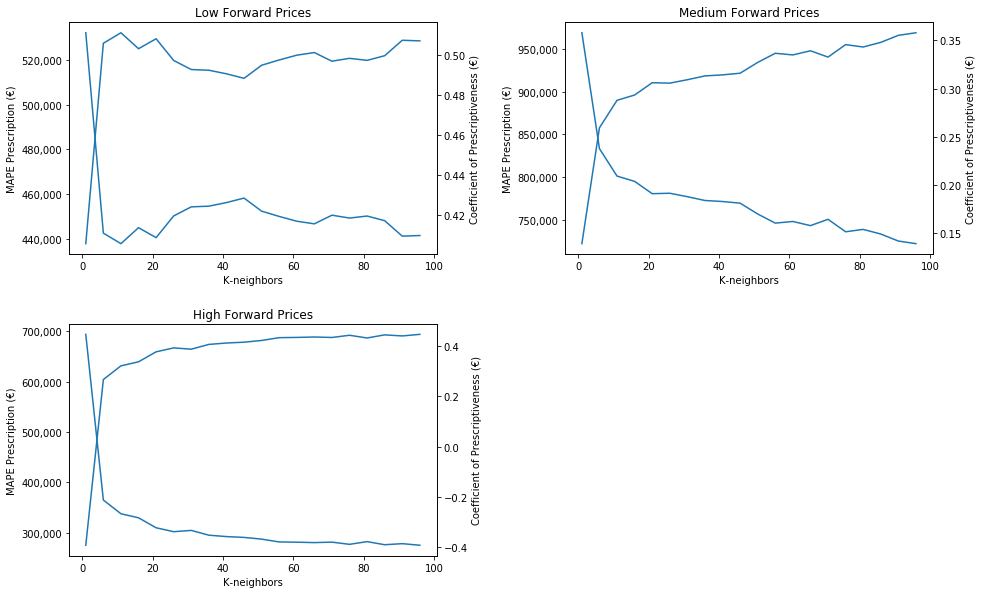

In [12]:
import matplotlib.ticker as mtick
for i in range(1,subplot_n):
    
    y_1 = MAE_pres[i]
    y_2 = CP_pres[i]
    ax = plt.subplot(3, 2, i)
    
    plt.plot(names,y_1)
    plt.ylabel('MAPE Prescription (€)')
    plt.xlabel('K-neighbors')
    ax2 = ax.twinx()
    ax2.plot(names,y_2)
    plt.title(graph_title[i-1])
    plt.ylabel('Coefficient of Prescriptiveness (€)')

    plt.grid(False)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y_1,  p: format(int(y_1), ',')))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.subplots_adjust(top=3, bottom=0.1, left=0.001, right=2.0, hspace=0.30,wspace=0.35)  
plt.show()
